In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.sparse.linalg import LinearOperator, cg
from scipy.sparse import dia_matrix

### Task 1

$
f(x) = \frac{(Ax, x)}{2} - (b,x) + c
$

$
\nabla f = (\nabla Ax, x) + (Ax, \nabla x) - b\nabla x = Ax - b = 0
$

Теперь надо показать что этот x - именно минимум. Для этого сделаем добавку к аргументу

(Если нужно сброшу выкладки (они на бумаге))

$
f(x + \delta) = ... = f(x) + \frac{1}{2}(A \delta, \delta)
$

Тут важно что теперь можно следующее значение как

$
x^1 - x^0 = t_0(Ax - f)
$

При это важно, что "прыжок" в сторону градиента - является параметром
Для удобства запишем $(Ax - f) = g^0$

Теперь определим шаг
$
f(x^1) = f(x^0 + t_0 r^0) = \frac{1}{2}(A(x^0 + t_0g^0), x^0 + t_0g^0) - (f, x^0 + t_0g^0) + C
$

$
\frac{df^1}{dt_0} = (Ax^0 - f, r^0) + t_0 (Ag^0, r^0) = 0
$

Таким образом можно определить шаг как:

$
\frac{(r^0, r^0)}{(Ag^0, r^0)}
$

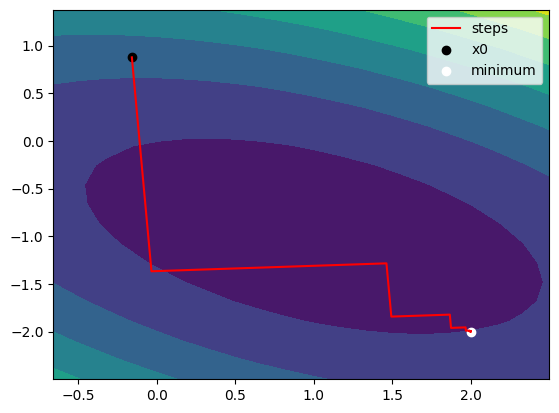

In [2]:

A = np.array([[3, 2], [2, 6]])
b = np.array([2, -8])
x0 = np.random.randn(2)
sol = np.linalg.inv(A) @ b

f = lambda x, y: 3 * x**2 + 4*x*y + 6*y**2 - 2*x + 8*y
def steepest_descent(A, b, steps):
    path = np.zeros((steps+1, 2))
    path[0,:] = x0
    for i in range(1, steps+1):
        rest = A.dot(path[i-1, :]) - b
        step = rest.dot(rest) / rest.dot(A.dot(rest))
        x = path[i-1, :] - step * rest
        path[i, :] = x
    return path

path = steepest_descent(A, b, 20)
X, Y = np.meshgrid(np.linspace(np.min(path[:, 0]) - 0.5, np.max(path[:, 0]) + 0.5, 20), np.linspace(np.min(path[:, 1]) - 0.5, np.max(path[:, 1]) + 0.5, 20))
plt.contourf(X, Y, f(X, Y))
plt.plot(path[:,0], path[:, 1], color = 'red', label='steps')
plt.scatter(path[0, 0], path[0,1], label='x0', c='black')
plt.scatter(sol[0],sol[1], label='minimum', c='white')
plt.legend()
plt.show()

### Task 4

In [3]:
with open("data.pkl", "rb") as input_file:
    data = pickle.load(input_file)
d, v, s, b = data['d'], data['v'], data['s'], data['b']
print("NEED MEMORY:", 50000 * 50000 * 8 / 10 ** 9, "GB")
v1 = np.array(v[:, 0])
v2 = np.array(v[:,1])
d = np.array(d)

# matrix_a = np.diag(d) + s[0]*v1 @ (v1.T) + s[1]*v2 @ (v2.T)
# print(np.linalg.matrix_rank(matrix_a)) # Rank
# del matrix_a
print('have a chance to allocate matrix, but no chance to use linalg.solve')
# np.linalg.solve(matrix_a, b)

NEED MEMORY: 20.0 GB
have a chance to allocate matrix, but no chance to use linalg.solve


In [4]:
def prod(x):
    v1_x = v1 @ x
    v2_x = v2 @ x
    return np.multiply(x, d) + s[0]*v1_x*v1 + s[1]*v2_x*v2
operator = LinearOperator(shape=(50000,50000), matvec=prod)
res = cg(operator,b, maxiter=1000) # Solving with Conjugate Gradient Method
x = res[0]
print(np.linalg.norm(operator.matvec(x)) / np.linalg.norm(x))

0.08421154908696485


### Task 6

$
F = \sum_0^{t-1}||y_i - Y_{i mod T} ||^2 = \sum_0^{t-1}(y_i - Y_{i mod T} )^2
$

Derivative is:

$
\frac{dF}{dY_{i mod T}} = - 2\sum_0^{t-1}(y_i - Y_{i mod T} )
$

$
\frac{dF}{dY_{i mod T}} = 0
$

$
Y^j = \frac{1}{n} \sum_0^{n}y_{jk}
$


## Smooth
$
F = \sum_0^{t-1}(y_i - Y_{i mod T} )^2 + \sum_1^{T-1}\gamma(Y_i - Y_{i-1})^2
$

$
\frac{dF}{dY_{i}} = 2\sum(Y_i - y_{ki}) + 2\gamma(Y_i - Y_{i-1}) + 2\gamma(Y_{i+1} - Y_i) = 0
$

$
-\gamma Y_{i-1} + (n + 2\gamma)Y_i - \gamma Y_{i+1} = \sum_1^{10}y_{ki}
$

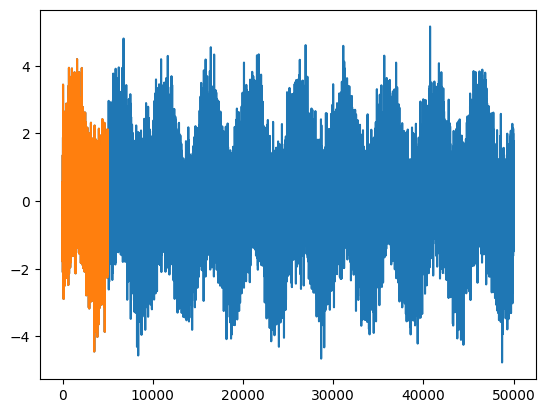

In [5]:
observations = np.load('y.npy')
plt.plot(observations)
np.random.seed(42)
n = 10
T = 5000
Y = np.reshape(observations, (n, T))
plt.plot(Y[0])

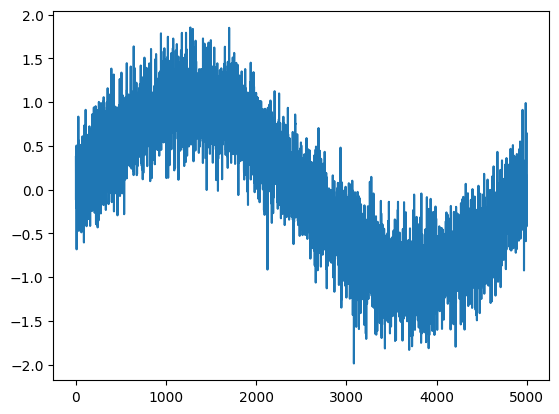

In [6]:
y_opt = Y.mean(axis=0)
plt.plot(y_opt)

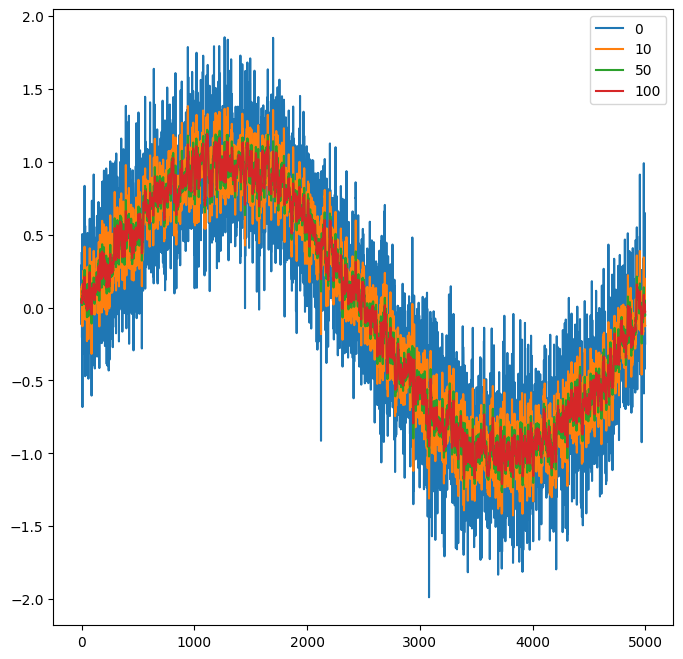

In [9]:
def smooth(gamma_par):
    one = np.ones(T)
    diags = np.array([-gamma_par*one, (n + 2*gamma_par)*one, -gamma_par*one])
    operator = dia_matrix((diags, [-1,0,1]), shape=(T, T)).tocsr()
    return cg(operator, Y.sum(axis=0), maxiter=50)

plt.figure(figsize=(8, 8))
for gamma in [0, 10, 50, 100]:
    plt.plot(smooth(gamma)[0], label=f'{gamma}')
plt.legend()
plt.show()